# PK Modelling Project - Mirtazapine
Using Non-linear kinetics to better match sample data

Updated settings

In [1]:
# Import basic dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle

# Import local scikit-pk (skpk) library - https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
sys.path.append(r'C:\Users\klty0\Desktop\scikit-pk\src')
#sys.path.append(r'C:\Users\Kenneth Leung\Desktop\scikit-pk\src')

# Import ODE modules
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import differential_evolution, shgo, basinhopping

np.set_printoptions(suppress=True)

In [2]:
# Graph settings
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Neue Einstellung'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 12
mpl.rc('axes', titlesize=18, titleweight=20, labelsize=14, facecolor=[0.9,0.9,0.9], edgecolor=[0.5, 0.5, 0.5], linewidth=0.5)
mpl.rc('xtick', labelsize=12, color=[0.3,0.3,0.3])
mpl.rc('ytick', labelsize=12)
mpl.rc('lines', linewidth=3, markersize=10)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', axisbelow=True)
savefigOpts = {'dpi': 100, 'transparent': True}

font_dirs = [r'C:\Users\klty0\Dropbox\Holmusk\Holmusk Templates\Fonts', ]
#font_dirs = [r'C:\Users\Kenneth Leung\Dropbox\Holmusk\Holmusk Templates\Fonts', ]
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = mpl.font_manager.createFontList(font_files)
mpl.font_manager.fontManager.ttflist.extend(font_list)

In [3]:
color_scheme = ['#11151D', '#3360CC', '#77B55B'] #Black, Blue, Green

#### Data Preparation
Creating list of lists with elements [subject_id, gender, age mean, age std]  
For gender, 0 = Male and 1 = Female

In [4]:
list_of_attr = [
    [1,0,24,4],
    [2,0,25,5],
    [3,0,25,4], 
    [4,0,51,8], 
    [5,0,68,5], 
    [6,0,33,6], 
    [7,0,69,3], 
    [8,0,21,1], 
    [9,0,23,4], 
    [10,0,27,9], 
    [11,0,28,6], 
    [12,0,22,1], 
    [13,1,23,3], 
    [14,1,51,4], 
    [15,1,40,8], 
    [16,1,68,3], 
    [17,1,23,6],
    [18,0,23,4],
    [19,0,25,4],
    [20,0,25,4],
    [21,0,32,4],
    [22,0,33,6],
    [23,0,69,3],
    [24,0,23,4],
    [25,0,24,4],
    [26,0,25,4],
    [27,0,26,7],
    [28,0,29,7],
    [29,0,30,8],
    [30,0,33,7],
    [31,0,32,4],
    [32,0,23,4],
    [33,0,25,4],
    [34,0,32,4],
    [35,0,23,4],
    [36,0,25,4],
    [37,0,25,4],
    [38,0,23,4],
    [39,1,40,8],
    [40,1,68,3],
    [41,1,23,4],
    [42,1,34,10],
    [50,1,27.5,7.4],
    [51,0,27.8,5.8]
]

In [5]:
df_attr = pd.DataFrame(list_of_attr, columns = ['subject_id','female','age_mean','age_sd'])

In [6]:
# Create dataframe of PK parameters (Subject ID, Cmax mean, Cmax SD, Tmax mean, Tmax SD, AUC mean, AUC SD, Study Reference, Freq, Dose)
list_of_pk_paras = [
    [1, 32.3, 11.4, 1.65, 0.70, 345, 103, 20, 'Single', 15],
    [2, 32.5, 9.7, 1.50, 0.60, 281, 83, 21, 'Single', 15],
    [3, 31.6, 12.8, 1.82, 0.71, 216, 46, 22, 'Single', 15],
    [4, 42.5, 16.3, 1.20, 0.30, 362, 66, 23, 'Single', 15],
    [5, 40.6, 13.8, 1.45, 0.73, 486, 161, 24, 'Single', 15],
    [6, 32.1, 8.1, 1.67, 0.65, 355, 199, 25, 'Single', 20],
    [7, 48.4, 20.1, 1.59, 0.74, 647, 294, 25, 'Single', 20],
    [8, 67.7, 20.6, 1.04, 0.10, 459, 136, 26, 'Single', 30],
    [9, 74.4, 23.5, 1.41, 0.74, 614, 177, 27, 'Single', 30],
    [10, 56.1, 13.9, 1.42, 0.56, 562, 134, 28, 'Single', 30],
    [11, 74.5, 37.8, 1.53, 0.78, 570, 137, 29, 'Single', 30],
    [12, 113.0, 55.8, 1.21, 0.40, 808, 285, 26, 'Single', 45],
    [13, 42.0, 8.2, 1.58, 0.68, 445, 94, 21, 'Single', 15],
    [14, 24.7, 6.9, 1.80, 0.80, 397, 218, 23, 'Single', 15],
    [15, 36.9, 11.3, 1.72, 1.00, 673, 248, 25, 'Single', 20],
    [16, 45.6, 20.2, 2.03, 1.64, 770, 270, 25, 'Single', 20],
    [17, 88.8, 38.7, 2.09, 1.84, 950, 298, 29, 'Single', 30],
    [18, 34.2, 13.4, 1.54, 0.51, 294, 100, 30, 'Multiple', 15],
    [19, 39.0, 12.0, 2.20, 1.50, 409, 116, 31, 'Multiple', 15],
    [20, 41.8, 7.7, 1.47, 0.75, 252, 48, 22, 'Multiple', 15],
    [21, 30.6, 7.8, 2.02, 1.11, 282, 51, 32, 'Multiple', 15],
    [22, 45.9, 24.3, 1.33, 0.43, 386, 170, 25, 'Multiple', 20],
    [23, 51.6, 29.4, 2.41, 1.66, 693, 357, 25, 'Multiple', 20],
    [24, 84.2, 36.5, 1.62, 0.82, 618, 205, 30, 'Multiple', 30],
    [25, 76.0, 33.0, 1.99, 1.65, 589, 142, 33, 'Multiple', 30],
    [26, 80.0, 24.0, 2.60, 1.40, 900, 254, 31, 'Multiple', 30],
    [27, 55.0, 8.9, 2.96, 1.24, 630, 160, 34, 'Multiple', 30],
    [28, 80.4, 18.5, 1.10, 0.30, 706, 235, 35, 'Multiple', 30],
    [29, 62.5, 15.8, 2.10, 1.08, 635, 196, 36, 'Multiple', 30],
    [30, 89.0, 21.0, 1.36, 0.39, 761, 140, 37, 'Multiple', 30],
    [31, 63.8, 16.8, 2.08, 0.93, 553, 96, 32, 'Multiple', 30],
    [32, 118.3, 47.3, 1.33, 0.85, 908, 308, 30, 'Multiple', 45],
    [33, 113.0, 29.0, 2.90, 1.80, 1350, 353, 31, 'Multiple', 45],
    [34, 102.1, 37.5, 1.79, 1.03, 786, 176, 32, 'Multiple', 45],
    [35, 141.2, 40.6, 1.06, 0.24, 1135, 247, 30, 'Multiple', 60],
    [36, 158.0, 41.0, 2.70, 1.60, 1793, 447, 31, 'Multiple', 60],
    [37, 181.0, 44.0, 3.10, 1.70, 2149, 476, 31, 'Multiple', 75],
    [38, 227.5, 31.1, 1.67, 0.58, 1797, 446, 30, 'Multiple', 80],
    [39, 59.9, 21.4, 2.33, 1.62, 769, 234, 25, 'Multiple', 20],
    [40, 62.0, 27.6, 2.31, 1.43, 860, 238, 25, 'Multiple', 20],
    [41, 81.7, 26.9, 2.29, 1.03, 958, 272, 34, 'Multiple', 30],
    [42, 80.0, 16.0, 1.39, 0.42, 785, 173, 37, 'Multiple', 30],
    [50, 181.1, 21.2, 0.5, 0.0, 814.5, 339.5, 50,'Single', 30],
    [51, 160.6, 36.4, 0.6, 0.2, 565.3, 169.5, 50,'Single', 30]
]

In [7]:
df_pk_paras = pd.DataFrame(list_of_pk_paras, columns = ['subject_id','Cmax_mean','Cmax_sd','Tmax_mean','Tmax_sd',
                                                        'AUC_mean','AUC_sd','reference','dosing', 'dose'])

In [8]:
df_subject_master = df_pk_paras.merge(df_attr, on = 'subject_id')
df_subject_master['V1'] = [152 if x == 'Single' else 107 for x in df_subject_master['dosing']]
df_subject_master

,subject_id,Cmax_mean,Cmax_sd,Tmax_mean,Tmax_sd,AUC_mean,AUC_sd,reference,dosing,dose,female,age_mean,age_sd,V1
0,1,32.3,11.4,1.65,0.70,345.0,103.0,20,Single,15,0,24.0,4.0,152
1,2,32.5,9.7,1.50,0.60,281.0,83.0,21,Single,15,0,25.0,5.0,152
2,3,31.6,12.8,1.82,0.71,216.0,46.0,22,Single,15,0,25.0,4.0,152
3,4,42.5,16.3,1.20,0.30,362.0,66.0,23,Single,15,0,51.0,8.0,152
4,5,40.6,13.8,1.45,0.73,486.0,161.0,24,Single,15,0,68.0,5.0,152
5,6,32.1,8.1,1.67,0.65,355.0,199.0,25,Single,20,0,33.0,6.0,152
6,7,48.4,20.1,1.59,0.74,647.0,294.0,25,Single,20,0,69.0,3.0,152
7,8,67.7,20.6,1.04,0.10,459.0,136.0,26,Single,30,0,21.0,1.0,152
8,9,74.4,23.5,1.41,0.74,614.0,177.0,27,Single,30,0,23.0,4.0,152
9,10,56.1,13.9,1.42,0.56,562.0,134.0,28,Single,30,0,27.0,9.0,152


#### Read in real data (from literature)

In [9]:
path = '.\Samples\Single Dosing'
files = os.listdir(path)
files_xls = [f for f in files if f[-4:] == 'xlsx']

In [10]:
files_xls

['subject03_ref22.xlsx',
 'subject06_ref25_adult_males_single_20mg.xlsx',
 'subject07_ref25_elderly_males_single_20mg.xlsx',
 'subject15_ref25_adult_females_single_20mg.xlsx',
 'subject16_ref25_elderly_females_single_20mg.xlsx']

In [11]:
list_of_raw_df = []

for file in files_xls:
    data = pd.read_excel(f'./Samples/Single Dosing/{file}')
    df = pd.DataFrame(data)
    df['time'] = round(df['time'],3)
    list_of_raw_df.append(df)

In [12]:
# 16 cohort subjects with real raw time-conc data
subject_id_list = [3,6,7,15,16,19,20,22,23,25,26,33,36,37,39,40]

In [13]:
list_of_samples = dict(zip(subject_id_list, list_of_raw_df))

In [14]:
period_start = 0
period_end = 120
intervals = 961 # Setting intervals to create intervals of 0.125h
time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=3)

In [15]:
list_of_samples

{3:       time       conc
 0    0.000   0.000000
 1    0.500   0.805901
 2    0.750   9.194387
 3    1.000  14.342469
 4    1.250  17.080560
 5    1.375  21.681612
 6    1.500  22.100900
 7    1.750  20.814170
 8    2.000  17.841936
 9    2.500  23.902240
 10   3.000  26.753267
 11   4.000  17.984159
 12   5.000  12.833210
 13   7.000  10.370522
 14   9.000   6.910594
 15  12.000   4.923195
 16  16.000   3.748534
 17  24.000   1.676076
 18  36.000   0.987345
 19  48.000   0.640339
 20  60.000   0.503423,
 6:       time       conc
 0     0.00   0.000000
 1     0.25   0.300885
 2     0.50   5.919149
 3     0.75  17.400989
 4     1.00  20.995162
 5     1.25  26.698899
 6     1.75  26.780900
 7     2.00  26.075169
 8     3.00  21.770772
 9     4.00  18.517888
 10    6.00  14.206050
 11    8.00  11.383233
 12   11.00  11.538462
 13   15.00   6.774228
 14   24.00   3.459678
 15   48.00   0.986657
 16   72.00   0.530009
 17   96.00   0.250917
 18  120.00   0.058476,
 7:       time       conc


#### Generate dataframe and reformat into clearer columns

In [16]:
def format_de_dataframe(de):
    df_de_results = pd.DataFrame(de, columns = ['subject_id', 'k_values', 'error', 'bounds'])
    df_de_results.loc[:, 'ka'] = df_de_results['k_values'].map(lambda x: x[0])
    df_de_results.loc[:, 'Bmax_k12'] = df_de_results['k_values'].map(lambda x: x[1])
    df_de_results.loc[:, 'k21'] = df_de_results['k_values'].map(lambda x: x[2])
    df_de_results.loc[:, 'ke'] = df_de_results['k_values'].map(lambda x: x[3])
    df_de_results.loc[:, 'KM'] = 14.3
    df_de_results.drop(columns = 'k_values')
    df_de_results_final = df_de_results.merge(df_subject_master, on = 'subject_id')
    return df_de_results_final

## Fixing KM

#### Single Dosing

In [92]:
subjects_single = [3,6,7,15,16]

In [93]:
# Initial parameters
F = 0.497 # Bioavailability
n = 3 # Number of compartments (inclusive of GI tract)

In [94]:
V1_single = 152 # Central volume of distribution for single dosing

In [95]:
def dC(t, C, ka, Bmax_k12, k21, ke, KM):
    
    A, C1, C2 = C[0], C[1], C[2]
    
    dC0dt = -ka*A
    dC1dt = (ka*(A/V1_single)) - (Bmax_k12*(C1/(KM + C1))) + k21*C2 - ke*C1
    dC2dt = (Bmax_k12*(C1 / (KM + C1))) - k21*C2

    dCdt = np.array([[dC0dt],[dC1dt],[dC2dt]]).reshape(n,)
    
    return dCdt

In [96]:
def ode_solver(p, subject_id):
    
    ka, Bmax_k12, k21, ke = p
    KM = 14.3
    
    # Initial concentration
    dose_mg = df_subject_master[df_subject_master.subject_id == subject_id]['dose'].values[0]   
    dose_ug = dose_mg * 1000 
    
    C_initial = np.zeros(n)
    C_initial[0] = (dose_ug * F)
    C_initial_1dim = C_initial.reshape(n,)

    output = solve_ivp(fun=dC, t_span=[period_start, period_end], t_eval = time_horizon, 
                       y0 = C_initial_1dim, args=(ka, Bmax_k12, k21, ke, KM,))
    return output

In [97]:
def objective_func(p, subject_id):

    output = ode_solver(p, subject_id)
    sample_df = list_of_samples[subject_id]
    output_dict = dict(zip(output.t, output.y[1])) 
    t_sample = sample_df['time'].values
    y_pred = [output_dict[t] for t in t_sample] 
    y_actual = sample_df['conc'].values
      
    error = y_actual - y_pred
    normalized_error = error / y_actual.max()
    squared_error = np.power(normalized_error,2)
    sum_error = np.sum(squared_error)
    mse = sum_error / y_actual.shape[0]
    
    Cmax_pred = np.amax(output.y[1])
    Cmax_pred_index = np.where(output.y[1] == Cmax_pred)[0][0]
    Tmax_pred = output.t[Cmax_pred_index]
    
    Cmax_actual = sample_df['conc'].max()
    Tmax_actual = sample_df.iloc[sample_df['conc'].argmax(), :1].values[0]
    
    Cmax_diff = np.abs(Cmax_actual - Cmax_pred)
    Tmax_diff = np.abs(Tmax_actual - Tmax_pred)
    
    Cmax_limit = 0.04 * Cmax_actual # Allow up to 4% variation
    Tmax_limit = 0.04 * Tmax_actual

    if Cmax_diff < Cmax_limit:
        Cmax_penalty = Cmax_diff
        Tmax_penalty = Tmax_diff
    else:
        Cmax_penalty = np.square(Cmax_diff)
        Tmax_penalty = np.square(Tmax_diff)
    
    total_penalty = Cmax_penalty + Tmax_penalty
    total_error = mse + (0.0018 * total_penalty) # Add weights
    
    return total_error

In [202]:
# Plot best fit from best results (differential evolution)
def plot_best_fit(p, subject_id):
    output = ode_solver(p, subject_id)
    plt.figure(figsize=(8,5))
    plt.xlabel('Time (h)')
    plt.ylabel('Plasma concentration (ug/L)')
    plt.title(f'Cohort ID = {subject_id}')
    plt.plot(output.t,output.y[1], color = color_scheme[1], label = 'Central concentration')
    #plt.plot(output.t,output.y[2], color = color_scheme[2], label = 'Peripheral concentration')
    print(f'Central Cmax = {np.amax(output.y[1])}, Peripheral Cmax = {np.amax(output.y[2])}')
    plt.legend()
    plt.scatter(list_of_samples[subject_id]['time'], list_of_samples[subject_id]['conc'], color = color_scheme[0], s = 25)
    plt.savefig(f'./Images/15 Raw Trajectories/Subject ID {subject_id}.png', **savefigOpts)

In [99]:
#  ka, Bmax_k12, k21, ke
bounds = [(0.4, 1.0), (17.0, 30.0), (0.4, 1.7), (0.05, 0.3)]

In [100]:
de_results_single = []

for subject_id in subjects_single:
    start = time.perf_counter()
    
    best_result = differential_evolution(objective_func, bounds, strategy='best2bin', popsize = 16,
                                         recombination=0.8, mutation = (0,1), maxiter = 1500, tol = 0.0003,
                                         args = (subject_id,), seed = 42)
    
    de_results_single.append([subject_id, best_result.x, best_result.fun, bounds])
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)
    print(f'Bounds: {bounds}')

3 DE completed in 61.43 seconds
[ 0.67727455 17.00043196  1.69998226  0.19981939] 0.029970045746786772
Bounds: [(0.4, 1.0), (17.0, 30.0), (0.4, 1.7), (0.05, 0.3)]
6 DE completed in 84.1 seconds
[ 0.61686245 17.00415744  0.40007082  0.20545899] 0.01497030033840692
Bounds: [(0.4, 1.0), (17.0, 30.0), (0.4, 1.7), (0.05, 0.3)]
7 DE completed in 98.39 seconds
[ 0.99991804 17.0074112   1.69998701  0.17142441] 0.02404422537874231
Bounds: [(0.4, 1.0), (17.0, 30.0), (0.4, 1.7), (0.05, 0.3)]
15 DE completed in 89.6 seconds
[ 0.69525115 29.99516945  1.69568805  0.20568895] 0.01826483234736229
Bounds: [(0.4, 1.0), (17.0, 30.0), (0.4, 1.7), (0.05, 0.3)]
16 DE completed in 101.1 seconds
[ 0.99999009 17.00321051  1.09809833  0.17183097] 0.018038224096692156
Bounds: [(0.4, 1.0), (17.0, 30.0), (0.4, 1.7), (0.05, 0.3)]


Central Cmax = 13.510259263069251, Peripheral Cmax = 0.019293657775363106
Central Cmax = 35.47828890800147, Peripheral Cmax = 0.025871203911262627
Central Cmax = 18.01102166580351, Peripheral Cmax = 0.0327054617071284
Central Cmax = 18.045823500952338, Peripheral Cmax = 0.012914280811133484
Central Cmax = 22.89918897374496, Peripheral Cmax = 0.03619284586217576


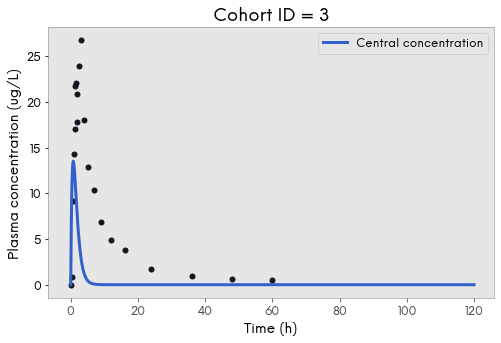

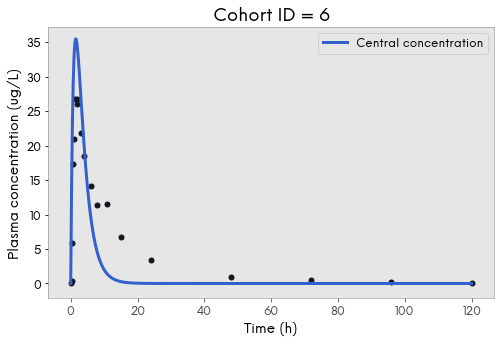

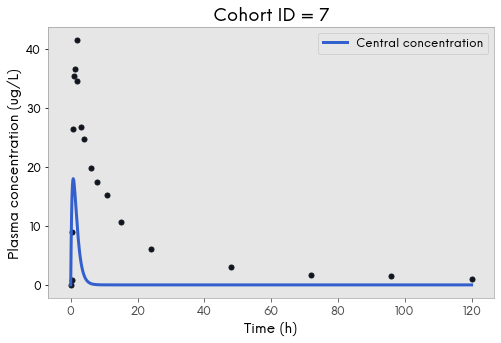

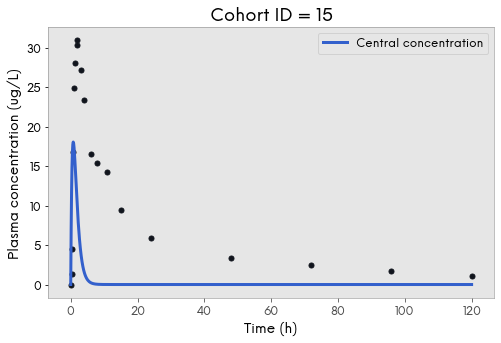

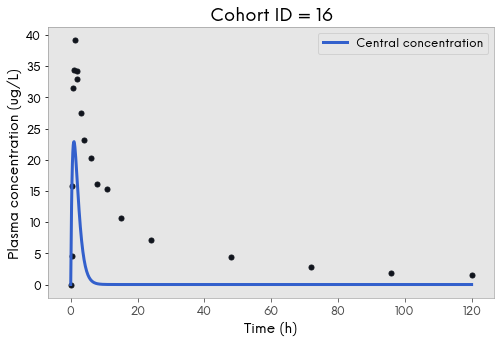

In [101]:
#KM 14.3
df_single = format_de_dataframe(de_results_single)
for subject_id in df_single.subject_id.values:
    k_values = list(df_single[df_single.subject_id == subject_id][['ka','Bmax_k12','k21','ke']].values[0])
    plot_best_fit(k_values, subject_id)

#### Improving fit of Subject 3

Central Cmax = 25.19443367621158, Peripheral Cmax = 10.092701770459026


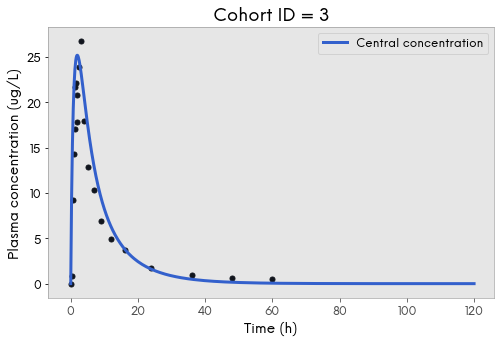

In [39]:
k_values = [1, 21.40747134, 1.29990666, 0.20834187]
plot_best_fit(k_values, 3)

### Fix ka and KM

In [161]:
def ode_solver(p, subject_id):
    
    Bmax_k12, k21, ke = p
    KM = 14.3
    ka = 0.9
    
    # Initial concentration
    dose_mg = df_subject_master[df_subject_master.subject_id == subject_id]['dose'].values[0]   
    dose_ug = dose_mg * 1000 
    
    C_initial = np.zeros(n)
    C_initial[0] = (dose_ug * F)
    C_initial_1dim = C_initial.reshape(n,)

    output = solve_ivp(fun=dC, t_span=[period_start, period_end], t_eval = time_horizon, 
                       y0 = C_initial_1dim, args=(ka, Bmax_k12, k21, ke, KM,))
    return output

In [162]:
def format_de_dataframe(de):
    df_de_results = pd.DataFrame(de, columns = ['subject_id', 'k_values', 'error', 'bounds'])
    df_de_results.loc[:, 'ka'] = 0.85
    df_de_results.loc[:, 'Bmax_k12'] = df_de_results['k_values'].map(lambda x: x[0])
    df_de_results.loc[:, 'k21'] = df_de_results['k_values'].map(lambda x: x[1])
    df_de_results.loc[:, 'ke'] = df_de_results['k_values'].map(lambda x: x[2])
    df_de_results.loc[:, 'KM'] = 14.3
    df_de_results.drop(columns = 'k_values')
    df_de_results_final = df_de_results.merge(df_subject_master, on = 'subject_id')
    return df_de_results_final

In [198]:
#  Bmax_k12, k21, ke
bounds = [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]

In [199]:
de_results_single = []

for subject_id in subjects_single:
    start = time.perf_counter()
    
    best_result = differential_evolution(objective_func, bounds, strategy='best2bin', popsize = 15,
                                         recombination=0.8, mutation = (0,1), maxiter = 1500, tol = 0.0003,
                                         args = (subject_id,), seed = 42)
    
    de_results_single.append([subject_id, best_result.x, best_result.fun, bounds])
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)
    print(f'Bounds: {bounds}')

3 DE completed in 51.09 seconds
[12.60989622  0.84997925  0.22251457] 0.040924628643725924
Bounds: [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]
6 DE completed in 55.47 seconds
[34.78024573  0.85        0.20873623] 0.02152290693281195
Bounds: [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]
7 DE completed in 51.72 seconds
[8.00097254 0.13980983 0.10196638] 0.0208037256529988
Bounds: [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]
15 DE completed in 42.42 seconds
[21.69242775  0.40671031  0.11341312] 0.0217961538168291
Bounds: [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]
16 DE completed in 16.8 seconds
[10.71821793  0.16022135  0.08930014] 0.014157745396161693
Bounds: [(8.0, 35.0), (0.1, 0.85), (0.05, 0.25)]


Central Cmax = 25.3261645745301, Peripheral Cmax = 8.705858039098967
Central Cmax = 25.983667005094546, Peripheral Cmax = 24.280334750025304
Central Cmax = 39.87707700900892, Peripheral Cmax = 25.918094570961497
Central Cmax = 30.92982219254385, Peripheral Cmax = 29.868540310778094
Central Cmax = 37.98775995610609, Peripheral Cmax = 30.990402629259222


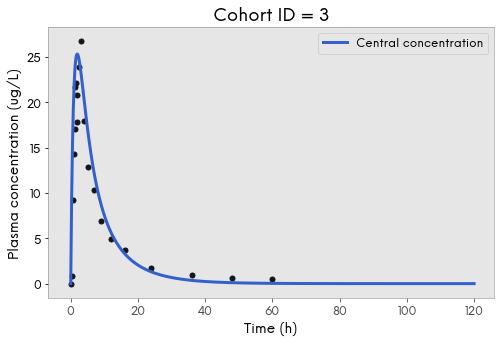

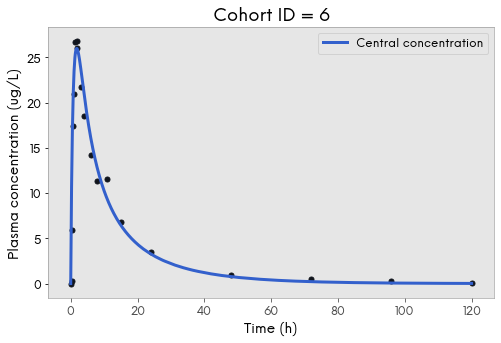

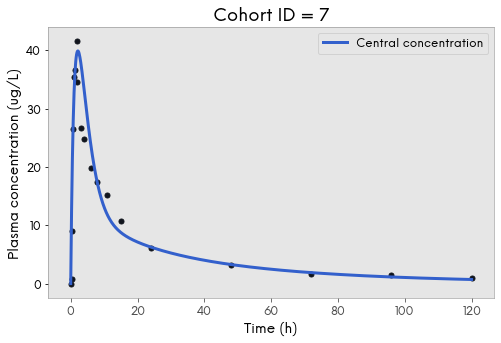

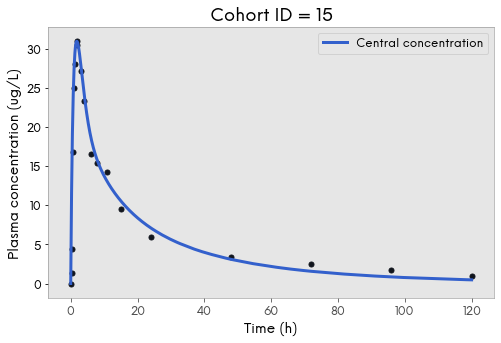

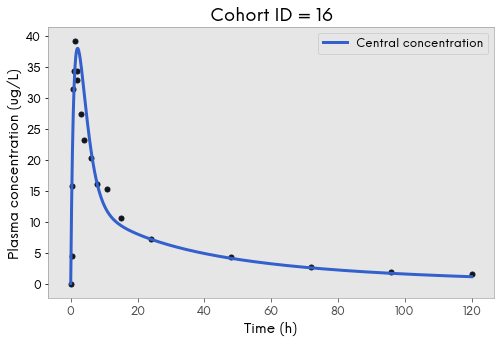

In [203]:
df_single = format_de_dataframe(de_results_single)
for subject_id in df_single.subject_id.values:
    k_values = list(df_single[df_single.subject_id == subject_id][['Bmax_k12','k21','ke']].values[0])
    plot_best_fit(k_values, subject_id)

In [204]:
df_single.to_excel('Final k values V3 (Single Dosing) - Fixed ka.xlsx', index = None)